# パッケージインストール

In [1]:
!pip install -q "openvino>=2024.3.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 MB 10.2 MB/s eta 0:00:00


In [2]:
!pip install -q onnx
!pip install -q onnx-graphsurgeon sng4onnx onnxsim onnx2tf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.2/146.2 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.4/56.4 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 445.0/445.0 kB 22.3 MB/s eta 0:00:00


In [3]:
!pip install -q paddlepaddle x2paddle

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.9/125.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.0/322.0 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 2.0 MB/s eta 0:00:00


# モデルファイル準備

In [ ]:
import torch
from torchvision import models
from torchvision.models import EfficientNet_B0_Weights

# PyTorch
pytorch_model = models.efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
pytorch_model.eval()
torch.save(pytorch_model, 'efficientnet_b0.pth')

In [5]:
# PyTorch -> ONNX
torch.onnx.export(
    pytorch_model,
    torch.randn(1, 3, 224, 224),
    'efficientnet_b0.onnx',
    input_names=['input'],
    output_names=['output'],
)

In [6]:
import openvino as ov

# ONNX -> OpenVINO
ov_model = ov.convert_model('efficientnet_b0.onnx')
ov.save_model(ov_model, 'efficientnet_b0.xml')

In [ ]:
# ONNX -> TensorFlow, TensorFlow Lite
!onnx2tf -i efficientnet_b0.onnx -otfv1pb
%cp saved_model/efficientnet_b0_float32.pb ./efficientnet_b0.pb
%cp saved_model/efficientnet_b0_float32.tflite ./efficientnet_b0.tflite

In [ ]:
# ONNX -> PaddlePaddle
!x2paddle --framework=onnx --model=efficientnet_b0.onnx --save_dir='pd_model'
%cp pd_model/inference_model/model.pdmodel ./efficientnet_b0.pdmodel
%cp pd_model/inference_model/model.pdiparams ./efficientnet_b0.pdiparams

# サンプル画像取得

In [9]:
!pip install -q imread_from_url

  Preparing metadata (setup.py) ... done


In [10]:
from imread_from_url import imread_from_url

image = imread_from_url('https://raw.githubusercontent.com/Kazuhito00/OpenVINO-Colab-Inference-Sample-using-various-frameworks-weights/main/sample.jpg')

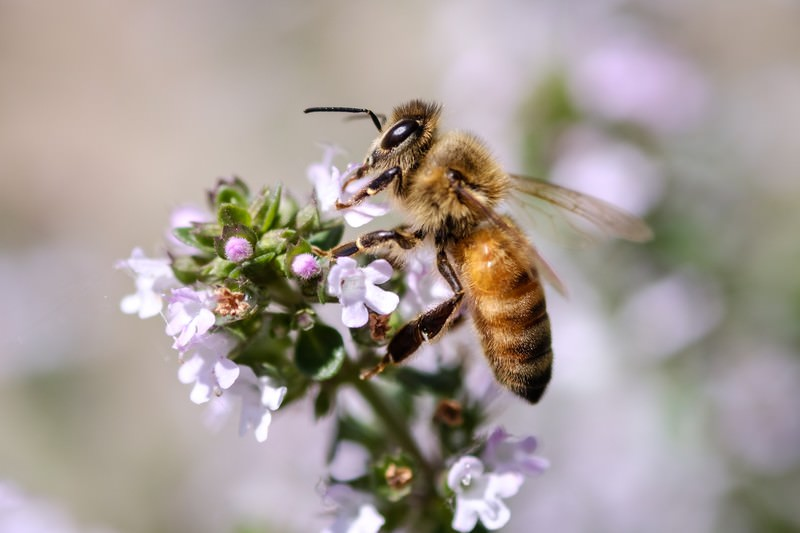

In [11]:
from google.colab.patches import cv2_imshow

cv2_imshow(image)

In [12]:
import cv2
import numpy as np

def preprocess_image(image):
    preprocessed_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    preprocessed_image = cv2.resize(preprocessed_image, (224, 224))

    preprocessed_image = preprocessed_image.astype(np.float32) / 255.0
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    preprocessed_image = (preprocessed_image - mean) / std

    bhwc_image = np.expand_dims(preprocessed_image, axis=0)

    bchw_image = np.transpose(preprocessed_image, (2, 0, 1))
    bchw_image = np.expand_dims(bchw_image, axis=0)

    return bchw_image, bhwc_image

# 前処理
bchw_image, bhwc_image = preprocess_image(image)

# PyTorch推論テスト

In [13]:
image_tensor = torch.tensor(bchw_image, dtype=torch.float32)

# 推論
with torch.no_grad():
    output = pytorch_model(image_tensor)

# 推論結果確認
result = output.numpy().squeeze()
top3_index = result.argsort()[-3:][::-1]
top3_score = result[top3_index]
print(top3_index)
print(top3_score)

[309  94 308]
[8.969412  4.2440233 3.666597 ]


# OpenVINO推論テスト

In [14]:
import openvino as ov

core = ov.Core()

In [15]:
# OpenVINOモデル読み込み
ov_model = core.read_model(model='efficientnet_b0.xml')
ov_compile_model = core.compile_model(model=ov_model, device_name="CPU")

# 推論
output = ov_compile_model([bchw_image])
output_layer = ov_compile_model.output(0)
result = output[output_layer]

# 推論結果確認
result = result.squeeze()
top3_index = result.argsort()[-3:][::-1]
top3_score = result[top3_index]
print(top3_index)
print(top3_score)

[309  94 308]
[8.973031  4.233986  3.6695192]


In [16]:
# ONNXモデル読み込み
ov_model = core.read_model(model='efficientnet_b0.onnx')
ov_compile_model = core.compile_model(model=ov_model, device_name="CPU")

# 推論
output = ov_compile_model([bchw_image])
output_layer = ov_compile_model.output(0)
result = output[output_layer]

# 推論結果確認
result = result.squeeze()
top3_index = result.argsort()[-3:][::-1]
top3_score = result[top3_index]
print(top3_index)
print(top3_score)

[309  94 308]
[8.969411  4.2440267 3.6665974]


In [17]:
# TensorFlowモデル読み込み
ov_model = core.read_model(model='efficientnet_b0.pb')
ov_compile_model = core.compile_model(model=ov_model, device_name="CPU")

# 推論
output = ov_compile_model([bhwc_image])
output_layer = ov_compile_model.output(0)
result = output[output_layer]

# 推論結果確認
result = result.squeeze()
top3_index = result.argsort()[-3:][::-1]
top3_score = result[top3_index]
print(top3_index)
print(top3_score)

[309  94 308]
[8.969411  4.2440267 3.6665974]


In [18]:
# TensorFlow Liteモデル読み込み
ov_model = core.read_model(model='efficientnet_b0.tflite')
ov_compile_model = core.compile_model(model=ov_model, device_name="CPU")

# 推論
output = ov_compile_model([bhwc_image])
output_layer = ov_compile_model.output(0)
result = output[output_layer]

# 推論結果確認
result = result.squeeze()
top3_index = result.argsort()[-3:][::-1]
top3_score = result[top3_index]
print(top3_index)
print(top3_score)

[309  94 308]
[8.969411  4.2440267 3.6665974]


In [19]:
# PaddlePaddleモデル読み込み
ov_model = core.read_model(model='efficientnet_b0.pdmodel')
ov_compile_model = core.compile_model(model=ov_model, device_name="CPU")

# 推論
output = ov_compile_model([bchw_image])
output_layer = ov_compile_model.output(0)
result = output[output_layer]

# 推論結果確認
result = result.squeeze()
top3_index = result.argsort()[-3:][::-1]
top3_score = result[top3_index]
print(top3_index)
print(top3_score)

[309  94 308]
[8.969411  4.2440267 3.6665974]


In [20]:
# PyTorch(直接読み込めないため、convert_model()使用)
ov_model = ov.convert_model(pytorch_model, example_input=torch.zeros((1, 3, 224, 224)))
ov_compile_model = core.compile_model(model=ov_model, device_name="CPU")

# 推論
output = ov_compile_model([bchw_image])
output_layer = ov_compile_model.output(0)
result = output[output_layer]

# 推論結果確認
result = result.squeeze()
top3_index = result.argsort()[-3:][::-1]
top3_score = result[top3_index]
print(top3_index)
print(top3_score)

[309  94 308]
[8.969411  4.2440267 3.6665974]
